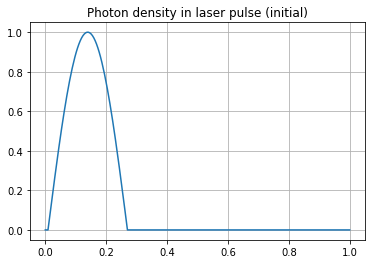

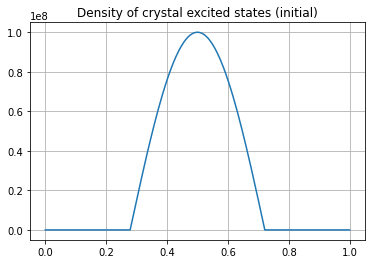

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to successfully call PETSc function 'MatSetValuesLocal'.
*** Reason:  PETSc error code is: 63 (Argument out of range).
*** Where:   This error was encountered inside /home/vagrant/src/radiasoft/codes/fenics-20201111.211147/dolfin/dolfin/la/PETScMatrix.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  74d7efe1e84d65e9433fd96c50f1d278fa3e3f3f
*** -------------------------------------------------------------------------


In [1]:
'''
File:  fn_simp_03.py

This more complicated test advances two equations simultaneously:
1) a laser pulse envelope, propagating to the right, while also dispersing
2) a static distribution of excited states in a crystal

Something is wrong...
I posted a question in the FEniCS user forum on 20201227
'''
from dolfin import *
import matplotlib.pyplot as plt

# Specify the BCs
def on_left(x, on_boundary):
    return (on_boundary and near(x[0], 0.))

def on_right(x, on_boundary):
    return (on_boundary and near (x[0], 1.))

# configuration parameters
V_x = 0.7212389380530974
n_ds = 226
ds = 0.004424778761061947
c_width = 0.4424778761061947
c_density = 1.e8
lp_width = 0.27876106194690264
lp_density = 1.

# create a 1D mesh on the interval [0,1]
mesh = UnitIntervalMesh(n_ds)
V = VectorFunctionSpace(mesh, "Lagrange", 1, dim=2)
v_1, v_2 = TestFunctions(V)

u = Function(V)
u_1, u_2 = split(u)
uprev = Function(V)
uprev_1, uprev_2 = split(uprev)

# instantiate the Dirichlet BCs
bc_left = DirichletBC(V, [Constant(0),Constant(0)], on_left)
bc_right = DirichletBC(V, [Constant(0),Constant(0)], on_right)
bc = [bc_left, bc_right]

# specify and apply the initial conditions
u0 = Expression(('x[0]>2.*ds && x[0]<(lp_width-2.*ds) ? \
                lp_density*sin(pi*(x[0]-2.*ds)/(lp_width-4.*ds)) : 0.', \
                'x[0]>=lp_width && x[0]<=(lp_width+c_width) ? \
                c_density*sin(pi*(x[0]-lp_width)/c_width) : 0.'),
                degree=2, lp_width=0.2, c_width=0.6, lp_density=1., c_density=1., ds=0.01)
u0.c_width = c_width
u0.lp_width = lp_width
u0.lp_density = lp_density
u0.c_density = c_density
u0.ds = ds
    
# project the above expression onto the solution vector
u = interpolate(u0, V)
uprev.assign(u)

n_steps = 100
time = 0.8
dt = time / (n_steps + 1)

DT = Constant(dt)
VX = Constant(V_x)

uplot = project(u, V)
uplot_1, uplot_2 = split(uplot)

# plot the curves at t=0
plot(uplot_1, title=('Photon density in laser pulse (initial)'))
plt.grid(True)
plt.show()
plt.close()

plot(uplot_2, title=('Density of crystal excited states (initial)'))
plt.grid(True)
plt.show()
plt.close()

# solve the system of equations
for i_loop in range(0, n_steps):
    F = ( (u_1-uprev_1)*v_1/DT + VX*u_1.dx(0)*v_1 ) * dx \
      + ( (u_2-uprev_2)*v_2/DT ) * dx

    solve(F==0, u, bc)
    uprev.assign(u)

uplot = project(u, V)
uplot_1, uplot_2 = split(uplot)

# plot the curves at the end of the simulation
plot(uplot_1, title=('Photon density in laser pulse (final)'))
plt.grid(True)
plt.show()
plt.close()

plot(uplot_2, title=('Density of crystal excited states (final)'))
plt.grid(True)
plt.show()
plt.close()